In [ ]:
from ast import ImportFrom
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
torch.cuda.is_available()
from torch.nn import functional as P

In [ ]:
train_dataset = datasets.MNIST(root = './data', train = True, transform = transforms.ToTensor(), download = True, )
test_dataset = datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15392796.05it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 477639.92it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4328448.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4046416.48it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
print(train_dataset.data.size())
print('-----------------------')
print(test_dataset.data.size())

torch.Size([60000, 28, 28])
-----------------------
torch.Size([10000, 28, 28])


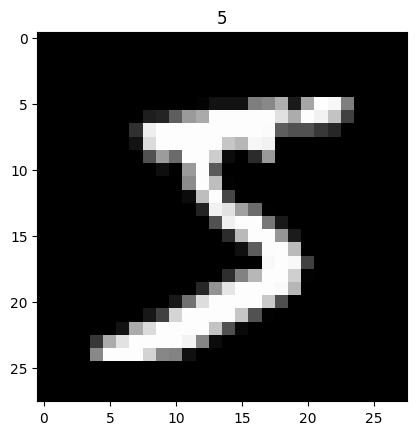

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset.data[0], cmap = 'gray')
plt.title('%i' % train_dataset.targets[0])
plt.show()

In [ ]:
batch_size = 100

train_load = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size)
test_load = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size)

In [ ]:
dataiter = iter(train_load)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100])


In [ ]:
print('num of images in training set: {}'.format(len(train_dataset)))
print('num of images in test set: {}'.format(len(test_dataset)))
print('num of batches in train loader: {}'.format(len(train_load)))
print('num of batches in test loader: {}'.format(len(test_load)))

num of images in training set: 60000
num of images in test set: 10000
num of batches in train loader: 600
num of batches in test loader: 100


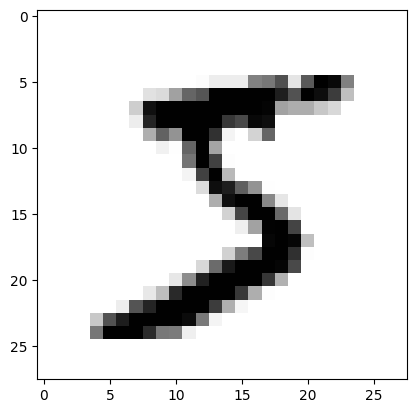

In [ ]:
plt.imshow(images[0].numpy().squeeze(), cmap = 'gray_r')

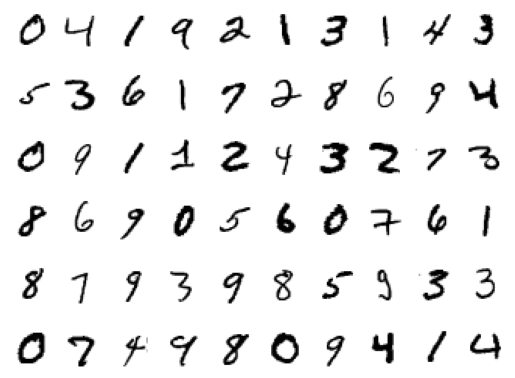

In [ ]:
figure = plt.figure()
num_of_images = 60
for i in range(1, num_of_images + 1):
  plt.subplot(6, 10, i)
  plt.axis('off')
  plt.imshow(images[i].numpy().squeeze(), cmap = 'gray_r')

In [ ]:

import torch.nn as an
class CNN (nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # input_size:28, same_padding=(filter_size-1)/2, 3-1/2-1:padding
    self.cnn1=nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
    # input_size-filter_size +2(padding)/stride + 1 = 28-3+2(1)/1+1-28
    self.batchnorm1=nn.BatchNorm2d(8)
    # output_channel:8, batch(8)
    self.relu=nn.ReLU()
    self.maxpool1=nn.MaxPool2d(kernel_size=2)
    #input_size=28/2-14
    self.cnn2=nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
    # same_padding: (5-1)/2-2:padding_size.
    self.batchnorm2=nn.BatchNorm2d(32)
    self.maxpool2=nn.MaxPool2d(kernel_size=2)
    # input_size=14/2-7
    # 32x7x7-1568
    self.fc1 =nn.Linear(in_features=1568, out_features=600)
    # self.dropout= nn. Dropout (p=0.5)
    self.fc2 =nn.Linear(in_features=600, out_features=10)
  def forward(self,x):
    out = self.cnn1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)
    out = self.maxpool1(out)
    out = self.cnn2(out)
    out = self.batchnorm2(out)
    out = self.relu(out)
    out = self.maxpool2(out)
    out = out.view(-1,1568)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    return out


In [ ]:

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 10
model=CNN().to(device)
loss_function= nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:

def train_CNN( model, criterion, optimizer, dataLoader, device):
  losses = []
  acc = []
  model.train()
  total = 0
  correct = 0.0
  running_loss = 0.0
  running_corrects = 0.0
  for data in dataLoader:
    images, labels= data
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    # print(outputs.shape)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    _, preds=torch.max(outputs, 1)
    running_loss += loss.item() * images.size(0)
    #This: correct += (preds == labels).sum().item() and this: running_corrects += torch.sum(preds == labels.data) are the same.
    running_corrects += torch.sum(preds == labels.data)
    total + labels.size(0)
  epoch_loss = running_loss / len(dataLoader)
  epoch_acc = running_corrects / len(dataLoader)
  # print('accuarcy 1', epoch_acc)
  # print('accuarcy 2', 100 correct/total)
  return epoch_acc, epoch_loss

In [ ]:

def vaildate_CNN(model, criterion, dataLoader, device):
  losses = []
  acc = []
  model.eval()
  running_loss = 0.0
  running_corrects = 0.0
  for data in dataLoader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(preds == labels.data)
  epoch_loss = running_loss / len(dataLoader)
  epoch_acc = running_corrects.double() / len(dataLoader)
  return epoch_acc, epoch_loss

In [ ]:

epochess = []
train_losses = []
test_losses = []
acc_training = []
acc_testing = []
for epoch in range (epochs):
  train_acc, train_epoch_loss = train_CNN (model, loss_function, optimizer, train_load, device)
  print('epoch', epoch, 'training loss', train_epoch_loss)
  train_losses.append(train_epoch_loss)
  print('epoch', epoch, 'training accuarcy', train_acc)
  acc_training.append(train_acc)
  test_acc, test_epoch_loss = vaildate_CNN (model, loss_function, test_load, device)
  print('epoch', epoch, 'testing loss', test_epoch_loss)
  test_losses.append(test_epoch_loss)
  print('epoch', epoch, 'testing accuarcy', test_acc)
  acc_testing.append(test_acc)
  epochess.append(epoch)

epoch 0 training loss 38.7182720589141
epoch 0 training accuarcy tensor(91.5300)
epoch 0 testing loss 14.313705193810165
epoch 0 testing accuarcy tensor(96.0100, dtype=torch.float64)
epoch 1 training loss 12.4861448132433
epoch 1 training accuarcy tensor(96.5117)
epoch 1 testing loss 9.71972421137616
epoch 1 testing accuarcy tensor(96.9600, dtype=torch.float64)
epoch 2 training loss 9.31682083918713
epoch 2 training accuarcy tensor(97.4400)
epoch 2 testing loss 7.841435563750565
epoch 2 testing accuarcy tensor(97.5500, dtype=torch.float64)
epoch 3 training loss 7.646065590670332
epoch 3 training accuarcy tensor(97.8667)
epoch 3 testing loss 6.774077179608867
epoch 3 testing accuarcy tensor(97.8000, dtype=torch.float64)
epoch 4 training loss 6.5661728865622235
epoch 4 training accuarcy tensor(98.1800)
epoch 4 testing loss 6.07567592500709
epoch 4 testing accuarcy tensor(98.0600, dtype=torch.float64)
epoch 5 training loss 5.794773369988737
epoch 5 training accuarcy tensor(98.3650)
epoch 

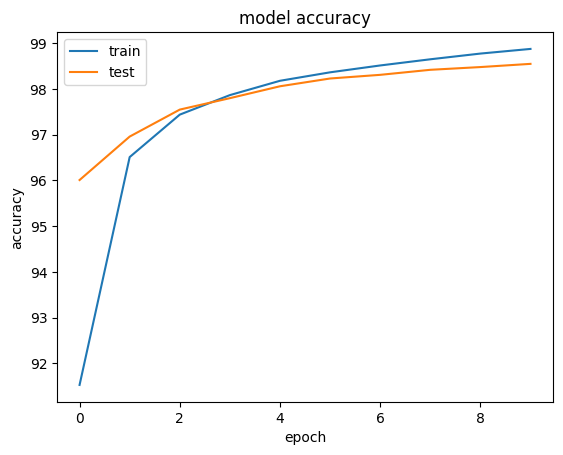

In [ ]:

import matplotlib.pyplot as plt
plt.plot(epochess, acc_training, acc_testing)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

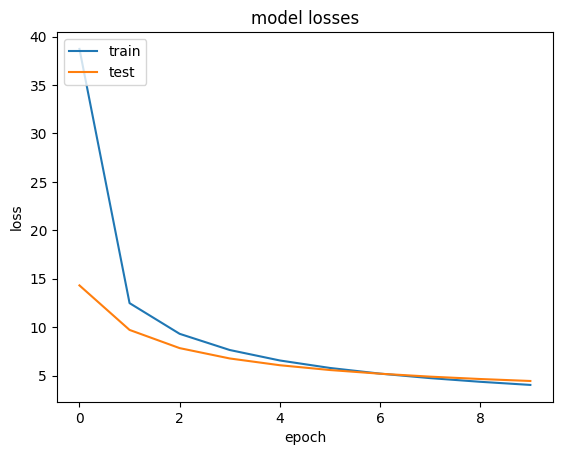

In [ ]:

plt.plot(epochess, train_losses, test_losses)
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/cnn_model.pt")

In [ ]:
accuarcy, loss = vaildate_CNN(model, loss_function, test_load, device)
print('model accuarcy is ', accuarcy)

model accuarcy is  tensor(98.5500, dtype=torch.float64)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model = CNN().to(device)
cnn_model.load_state_dict(torch.load("/content/drive/MyDrive/cnn_model.pt"))

In [ ]:
!pip install shap==0.30.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.1/244.1 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.9 MB/s eta 0:00:00
  Created wheel for shap: filename=shap-0.30.1-cp310-cp310-linux_x86_64.whl size=356176 sha256=2cb69d293d3cf03df46de6926f3d56a1c9a6389c5fb45ce848a78961c60f4c51
  Stored in directory: /root/.cache/pip/wheels/11/3d/7f/bd912d3c815925392a52a3b2078657a0e29c0c36eac2f52c3a
Successfully built shap


In [ ]:
def get_background_classess(data_loader):
  mean = torch.zeros([10, 1, 28, 28])
  label_count = torch.zeros(10)
  for images, labels in data_loader:
    for image, label in zip(images, labels):
      mean[label] += image
      label_count[label] += 1
  for i in range(10):
    mean[i] = mean[i] / label_count[i]
  return mean

In [ ]:
background = get_background_classess(train_load).to(device)

In [ ]:
batch = iter(train_load)
images, labels = next(batch)
test_images = images[1:4].to(device)

In [ ]:
labels[1:4]
# pic 1 has label 0, pic 2 has label 4, pic 3 has label 1

tensor([0, 4, 1])

In [ ]:
test_images.shape
# we have 3 pics theyr width and hight is 28 * 28 and we have only one channel

torch.Size([3, 1, 28, 28])

In [ ]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import shap

test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

In [ ]:
def shap_plot(model, test_images, test_numpy, background):
  e = shap.GradientExplainer(model, background)
  shap_values = e.shap_values(test_images)
  shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
  shap.image_plot(shap_numpy, -test_numpy)

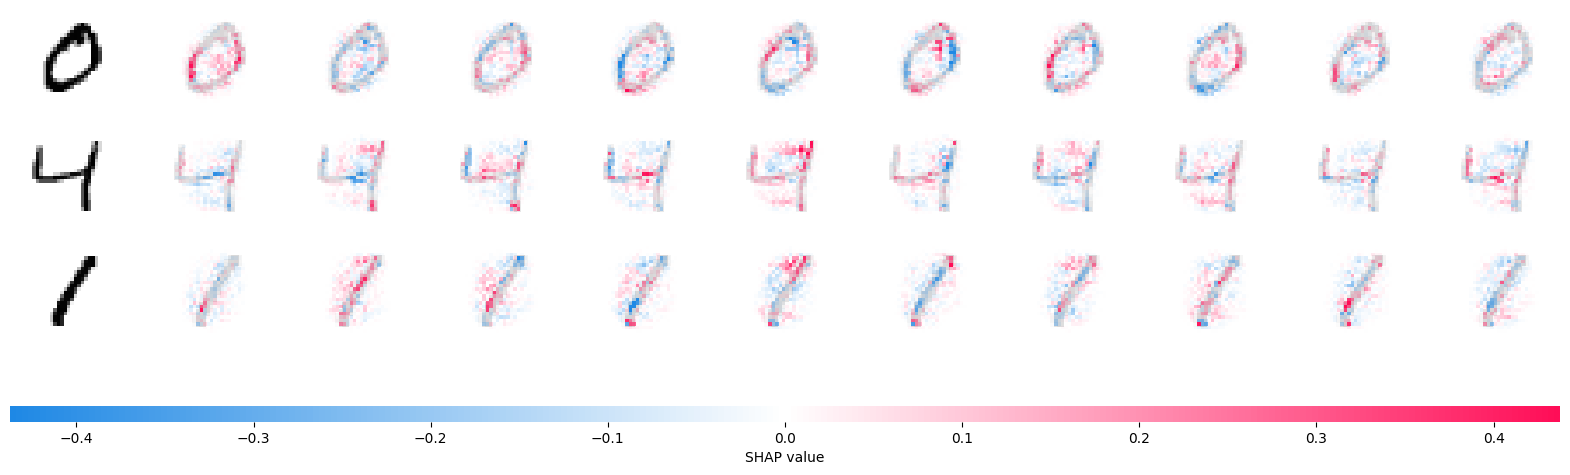

In [ ]:
shap_plot(cnn_model, test_images, test_numpy, background)